In [3]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
import pickle
import os

# === CONFIG BASE DE DONNÉES ===
user = "marjoriealbarico"
password = "postgres"
host = "localhost"
port = "5432"
database = "poitiers"

engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")

# === CHARGEMENT ===
print("📥 Chargement des données depuis PostgreSQL...")
df = pd.read_sql("SELECT * FROM horaires_gtfs_complet", con=engine)

# === PRÉTRAITEMENT ===
print("🧹 Prétraitement des horaires...")
df["departure_time"] = pd.to_datetime(df["departure_time"].astype(str), format="%H:%M:%S", errors="coerce")
df["departure_hour"] = df["departure_time"].dt.hour

print("🕒 Exemple d'heures présentes :", sorted(df["departure_hour"].dropna().unique()))

# === SIMULATION AFFLUENCE ===
print("🎲 Simulation de la colonne 'affluence'...")
conditions = [
    df["departure_hour"].between(6, 9),
    df["departure_hour"].between(11, 13),
    df["departure_hour"].between(16, 19),
]
choices = [2, 1, 2]  # Élevée, Moyenne, Élevée
df["affluence"] = np.select(conditions, choices, default=0)

# Vérification de la distribution
val_counts = df["affluence"].value_counts()
print("📊 Répartition initiale :\n", val_counts.rename({0: "Faible", 1: "Modérée", 2: "Élevée"}))

# Fallback si une seule classe
if len(val_counts) < 2:
    print("⚠️ Trop peu de classes détectées. Utilisation d'une simulation aléatoire.")
    df["affluence"] = np.random.choice([0, 1, 2], size=len(df), p=[0.4, 0.3, 0.3])

# === ENCODAGE ===
print("🔢 Encodage route_id et stop_id...")
le_route = LabelEncoder()
le_stop = LabelEncoder()

df["route_id_enc"] = le_route.fit_transform(df["route_id"].astype(str))
df["stop_id_enc"] = le_stop.fit_transform(df["stop_id"].astype(str))

X = df[["route_id_enc", "stop_id_enc", "departure_hour"]].fillna(0).astype(int)
y = df["affluence"]

# === ENTRAÎNEMENT ===
print("🧠 Entraînement RandomForest (class_weight=balanced)...")
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"✅ Score de test : {score:.2f}")

# === CLASSIFICATION REPORT ADAPTÉ ===
print("\n📈 Rapport de classification :")
y_pred = clf.predict(X_test)
labels_presentes = unique_labels(y_test, y_pred)
noms_labels = ["Faible", "Modérée", "Élevée"]
print(classification_report(y_test, y_pred, target_names=[noms_labels[i] for i in labels_presentes]))

# === SAUVEGARDE ===
os.makedirs("modeles", exist_ok=True)
with open("modeles/affluence_model.pkl", "wb") as f:
    pickle.dump(clf, f)
with open("modeles/route_encoder.pkl", "wb") as f:
    pickle.dump(le_route, f)
with open("modeles/stop_encoder.pkl", "wb") as f:
    pickle.dump(le_stop, f)

print("💾 Modèle et encodeurs sauvegardés dans le dossier 'modeles'")


📥 Chargement des données depuis PostgreSQL...
🧹 Prétraitement des horaires...
🕒 Exemple d'heures présentes : []
🎲 Simulation de la colonne 'affluence'...
📊 Répartition initiale :
 affluence
Faible    138016
Name: count, dtype: int64
⚠️ Trop peu de classes détectées. Utilisation d'une simulation aléatoire.
🔢 Encodage route_id et stop_id...
🧠 Entraînement RandomForest (class_weight=balanced)...
✅ Score de test : 0.33

📈 Rapport de classification :
              precision    recall  f1-score   support

      Faible       0.40      0.32      0.36     13803
     Modérée       0.30      0.34      0.32     10339
      Élevée       0.30      0.34      0.32     10362

    accuracy                           0.33     34504
   macro avg       0.33      0.33      0.33     34504
weighted avg       0.34      0.33      0.33     34504

💾 Modèle et encodeurs sauvegardés dans le dossier 'modeles'


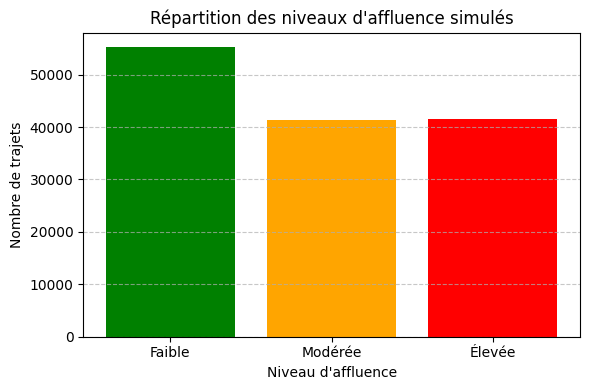

In [4]:
import matplotlib.pyplot as plt

# Affichage de la répartition en barres
val_counts_sorted = df["affluence"].value_counts().sort_index()
label_map = {0: "Faible", 1: "Modérée", 2: "Élevée"}
labels = [label_map[i] for i in val_counts_sorted.index]

plt.figure(figsize=(6, 4))
plt.bar(labels, val_counts_sorted.values, color=["green", "orange", "red"])
plt.title("Répartition des niveaux d'affluence simulés")
plt.xlabel("Niveau d'affluence")
plt.ylabel("Nombre de trajets")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
